In [1]:
import numpy as np
import suite2p
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Sequence, Dict, Any
from scipy.stats import kde, pearsonr
import numpy as np
import pandas as pd
import os
import pickle
from scipy.signal import find_peaks
import cottage_analysis as cott
from cottage_analysis.imaging.common import align_timestamps, find_frames


# Suite2p visualization

## Filepath

In [2]:
# filepath
rawdata_root = '/camp/lab/znamenskiyp/data/instruments/raw_data/projects/'
root = '/camp/lab/znamenskiyp/home/shared/projects/'
project = 'hey2_3d-vision_20210716'
data_dir = ''
mouse = 'PZAH2.1b'
session = 'S20210916'
recording = 'R163430'
protocol = 'SphereSparseNoise'
suite2p_dir = 'suite2p_rois_0/suite2p/plane0/'
trace_dir = 'suite2p_traces_0/'

def generate_filefolder(root, rawdata_root, project, data_dir, mouse, session, recording, protocol):
    rawdata_folder = rawdata_root + project + '/' + data_dir + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    preprocess_folder = root + project + '/' + data_dir + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    analysis_folder = root + project + '/' + data_dir + 'Analysis/' + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    
    return rawdata_folder, preprocess_folder, analysis_folder

def generate_suite2p_folder(root, project, data_dir, mouse, session, recording, protocol, suite2p_dir, trace_dir):
    suite2p_folder = root + project + '/' + data_dir + mouse + '/' + session + '/' + suite2p_dir
    protocol_folder = root + project + '/' + data_dir + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    trace_folder = protocol_folder +  protocol + '_' + trace_dir
    
    return suite2p_folder, protocol_folder, trace_folder


rawdata_folder, preprocess_folder, analysis_folder = generate_filefolder(root, rawdata_root, project, data_dir, mouse, session, recording, protocol)
print(rawdata_folder, preprocess_folder, analysis_folder)

suite2p_folder, protocol_folder, trace_folder = generate_suite2p_folder(root, project, data_dir, mouse, session, recording, protocol, suite2p_dir, trace_dir)
print(suite2p_folder, protocol_folder, trace_folder)

if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)
print(trace_folder)
    

/camp/lab/znamenskiyp/data/instruments/raw_data/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/R163430_SphereSparseNoise/ /camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/R163430_SphereSparseNoise/ /camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/Analysis/PZAH2.1b/S20210916/R163430_SphereSparseNoise/
/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/suite2p_rois_0/suite2p/plane0/ /camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/R163430_SphereSparseNoise/ /camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/R163430_SphereSparseNoise/SphereSparseNoise_suite2p_traces_0/
/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/R163430_SphereSparseNoise/SphereSparseNoise_suite2p_traces_0/


## Load files

In [3]:
# Load files
F = np.load(suite2p_folder+'F.npy', allow_pickle=True)
Fneu = np.load(suite2p_folder+'Fneu.npy', allow_pickle=True)
spks = np.load(suite2p_folder+'spks.npy', allow_pickle=True)
stat = np.load(suite2p_folder+'stat.npy', allow_pickle=True)
ops =  np.load(suite2p_folder+'ops.npy', allow_pickle=True)
ops = ops.item()
iscell = np.load(suite2p_folder+'iscell.npy', allow_pickle=True)[:,0]
output_op = ops

## Extract Traces

In [7]:
f_cells = np.load(Path(output_op['save_path']).joinpath('F.npy'))
f_neus = np.load(Path(output_op['save_path']).joinpath('Fneu.npy'))
spks = np.load(Path(output_op['save_path']).joinpath('spks.npy'))
f_cells.shape, f_neus.shape, spks.shape

((359, 218389), (359, 218389), (359, 218389))

In [4]:
f_cells = np.load(Path(trace_folder).joinpath('F.npy'))
f_neus = np.load(Path(trace_folder).joinpath('Fneu.npy'))
spks = np.load(Path(trace_folder).joinpath('spks.npy'))
f_ast = np.load(Path(trace_folder).joinpath('Fast.npy'))
f_cells.shape, f_neus.shape, spks.shape, f_ast.shape

((359, 184409), (359, 184409), (359, 184409), (359, 184409))

# Process vis-stim loggers & harp

## Process vis-stim info

In [5]:
with open(protocol_folder+'img_VS.pickle', 'rb') as handle:
    img_VS = pickle.load(handle)
    
img_VS['Stim'] = np.nan
img_VS.loc[img_VS.Depth.notnull(), 'Stim'] = 1
img_VS.loc[img_VS.Depth<0, 'Stim'] = 0
img_VS.loc[((img_VS[img_VS.Depth<0]).index.values-1),'Stim'] = 0

img_VS_simple = img_VS[(img_VS['Stim'].diff()!=0) & (img_VS['Stim'].notnull())]
img_VS_simple.Depth = np.round(img_VS_simple.Depth,2)
img_VS_simple

/camp/home/hey2/.conda/envs/2p_analysis/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,HarpTime,ImagingFrame,Photodiode,ElapsedTime,VisStim_Frame,SphereID,Depth,Azimuth,Elevation,EyeZ,Stim
1241,4.571217e+06,1241,21,47.696992,5135,1.0,0.20,10.0,5.0,7.080702,1.0
2134,4.571247e+06,2134,12,77.486976,8425,1511.0,0.20,20.0,-25.0,12.921180,0.0
2436,4.571257e+06,2436,12,87.580000,9241,1517.0,0.63,150.0,-40.0,15.660563,1.0
3333,4.571287e+06,3333,196,117.524992,12502,3029.0,0.63,-10.0,-35.0,19.599519,0.0
3635,4.571297e+06,3635,203,127.597984,13624,3033.0,2.00,50.0,20.0,22.395353,1.0
...,...,...,...,...,...,...,...,...,...,...,...
178352,4.577130e+06,178352,13,5959.870976,655801,225175.0,0.20,130.0,5.0,830.200066,0.0
178653,4.577140e+06,178653,201,5969.921984,656928,225179.0,0.63,-20.0,-40.0,832.088397,1.0
179551,4.577170e+06,179551,14,5999.876000,660095,226714.0,0.63,180.0,40.0,833.793877,0.0
179852,4.577180e+06,179852,19,6009.948000,661199,226719.0,2.00,-10.0,-35.0,835.118776,1.0


In [6]:
# Find the frame number of each vis-stim trial
depth_list = [0.2, 0.63, 2]
stim_dict = {}
for istim in depth_list:  
    stim_dict['stim'+str(istim)] = {}
    stim_dict['stim'+str(istim)]['start'] = img_VS_simple[(img_VS_simple['Depth']==istim) & (img_VS_simple['Stim']==1)].index.values
    stim_dict['stim'+str(istim)]['stop'] = img_VS_simple[(img_VS_simple['Depth']==istim) & (img_VS_simple['Stim']==0)].index.values

In [7]:
# Find frames for blank period
blank_points = img_VS_simple.index.values[1:-1]
stim_dict['blank'] = {}
stim_dict['blank']['start'] = blank_points[0::2] + 1
stim_dict['blank']['stop'] = blank_points[1::2] - 1

# Basic visualization of neural activity

In [8]:
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy

In [9]:
# dF/F
def dFF(f_cells):
    f_mean = np.average(f_cells,axis=1).reshape(-1,1)
    dffs = (f_cells-f_mean)/f_mean
    return dffs
dffs = dFF(f_cells)
dffs_ast = dFF(f_ast)
dffs.shape, dffs_ast.shape

((359, 184409), (359, 184409))

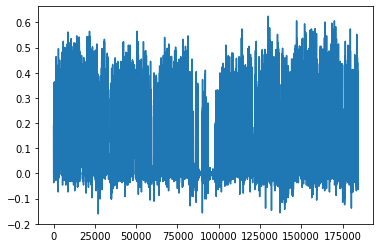

In [10]:
# Speed
speeds = img_VS.EyeZ.diff()/img_VS.HarpTime.diff()
speeds[0] = 0
plt.plot(speeds)

In [11]:
# Select which rois to visualize 
which_rois = (np.arange(f_cells.shape[0]))[iscell.astype('bool')]
which_rois

array([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  38,  39,  41,
        42,  43,  44,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  83,  84,
        85,  86,  87,  88,  89,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 104, 105, 107, 108, 109, 110, 111, 112, 114,
       115, 116, 117, 118, 120, 121, 122, 124, 125, 127, 128, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 152, 153, 154, 156, 157, 158, 159,
       161, 163, 164, 165, 166, 168, 170, 171, 172, 173, 174, 177, 178,
       179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 20

In [12]:
# Utils
# Find the min trial number for all depths
def find_min_trial_num_all_depths(stim_dict, depth_list, isStim=True):
    if isStim:
        trial_nums = []
        for idepth in range(len(depth_list)):
            depth = depth_list[idepth]
            frame_dict = stim_dict['stim'+str(depth)]
            trial_nums.append(len(frame_dict['start']))
        trial_nums = np.array(trial_nums)
    #     if np.all(trial_nums==trial_nums[0]):
    #         print('Checked all trial nums are the same')
        if not np.all(trial_nums==trial_nums[0]):
            print('Trials nums are not the same. Take the min trial num.')
        trial_num = np.min(trial_nums)
    else: 
        trial_num = len(stim_dict['blank']['stop'])
    
    return trial_num


# Find the min frame number of each trial for each ROI
def find_min_frame_num_per_trial(depth_list, stim_dict, isStim=True):
    if isStim: 
        trial_num = find_min_trial_num_all_depths(stim_dict, depth_list)
        frame_num_arr = np.zeros((len(depth_list),trial_num))
        for idepth in range(len(depth_list)):
            for itrial in range(trial_num):
                frame_start = stim_dict['stim'+str(depth_list[idepth])]['start'][itrial]
                frame_stop = stim_dict['stim'+str(depth_list[idepth])]['stop'][itrial]
                frame_num = frame_stop - frame_start+1
                frame_num_arr[idepth, itrial] = frame_num
    else:
        trial_num = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=False)
        frame_num_arr = np.zeros(trial_num)
        for itrial in range(trial_num):
            frame_start = stim_dict['blank']['start'][itrial]
            frame_stop = stim_dict['blank']['stop'][itrial]
            frame_num = frame_stop - frame_start+1
            frame_num_arr[itrial] = frame_num
    
    return int(np.min(frame_num_arr))


# Create an array to store the traces for each roi, format: depth x trial x frames_per_trial
def create_trace_arr_per_roi(which_roi, dffs, depth_list, stim_dict, isStim=True, blank_period=0, frame_rate=30):
    trial_num = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=isStim)
    frame_num_pertrial = find_min_frame_num_per_trial(depth_list, stim_dict, isStim=isStim)
    frame_num_pertrial = frame_num_pertrial + blank_period*frame_rate*2
    dff = dffs[which_roi,:]
    

    if isStim:
        trace_arr = np.zeros((len(depth_list),trial_num, frame_num_pertrial))

        for idepth in range(0,len(depth_list)):
            depth = depth_list[idepth]
            for itrial in range(0, trial_num):
                frame_start = stim_dict['stim'+str(depth)]['start'][itrial] - blank_period*frame_rate
                trace_arr[idepth, itrial,:] = dff[frame_start:(frame_start+frame_num_pertrial)]

    
    else:
        trace_arr = np.zeros((1,trial_num, frame_num_pertrial))

        for itrial in range(0, trial_num):
            frame_start = stim_dict['blank']['start'][itrial]
            trace_arr[0, itrial,:] = dff[frame_start:(frame_start+frame_num_pertrial)]
        
    
    return trace_arr


# Create an array to store the speed for each trial, format: depth x trial x frames_per_trial
def create_speed_arr(speeds, depth_list, stim_dict, isStim=True, blank_period=0, frame_rate=30):
    trial_num = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=isStim)
    frame_num_pertrial = find_min_frame_num_per_trial(depth_list, stim_dict, isStim=isStim)
    frame_num_pertrial = frame_num_pertrial + blank_period*frame_rate*2
    
    if isStim:
        speed_arr = np.zeros((len(depth_list),trial_num, frame_num_pertrial))

        for idepth in range(0,len(depth_list)):
            depth = depth_list[idepth]
            for itrial in range(0, trial_num):
                frame_start = stim_dict['stim'+str(depth)]['start'][itrial] - blank_period*frame_rate
                speed_arr[idepth, itrial,:] = speeds[frame_start:(frame_start+frame_num_pertrial)]

    else:
        speed_arr = np.zeros((1,trial_num, frame_num_pertrial))

        for itrial in range(0, trial_num):
            frame_start = stim_dict['blank']['start'][itrial]
            speed_arr[0, itrial,:] = speeds[frame_start:(frame_start+frame_num_pertrial)]

    
    return speed_arr


def create_optic_flow_arr(speed_arr, depth_list):
    optic_arr = np.zeros(speed_arr.shape)
    for idepth in range(len(depth_list)):
        optic_arr[idepth,:,:] = speed_arr[idepth,:,:]/depth_list[idepth]
    
    return optic_arr


def normalize_scale(arr, average_axis=1, scalek=1):
    if average_axis==1:
        arr_normed = (arr - np.average(arr, axis=average_axis).reshape(-1,1))/(np.max(arr,axis=average_axis)-np.min(arr,axis=average_axis)).reshape(-1,1)
    elif average_axis==0:
        arr_normed = (arr - np.average(arr, axis=average_axis))/(np.max(arr)-np.min(arr))

    arr_scaled = arr_normed * scalek
            
    
    return arr_scaled


def segment_arr(arr_idx, segment_size):
    batch_num = len(arr_idx)//segment_size
    segment_starts = np.arange(0,batch_num*segment_size+1,segment_size)
    segment_ends = np.arange(segment_size,batch_num*segment_size+segment_size,segment_size)
    if len(arr_idx)%segment_size!=0:
        segment_ends = np.concatenate((segment_ends, (arr_idx[-1]+1).reshape(-1)))
    
    return segment_starts, segment_ends 


isStim = True
trial_num = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=isStim)
frame_num_pertrial = find_min_frame_num_per_trial(depth_list, stim_dict, isStim=isStim)
trace_arr = create_trace_arr_per_roi(0,dffs, depth_list, stim_dict, isStim=isStim)
speed_arr = create_speed_arr(speeds, depth_list, stim_dict, isStim=isStim)
segment_starts, segment_ends = segment_arr(arr_idx=np.arange(20), segment_size = 50)
trial_num, frame_num_pertrial, trace_arr.shape, speed_arr.shape, segment_starts, segment_ends



(50, 894, (3, 50, 894), (3, 50, 894), array([0]), array([20]))

In [13]:
# Plotting utils
def get_confidence_interval(arr, sig_level=0.05, mean_arr=[]):
#     CI_low, CI_high = scipy.stats.t.interval(0.95, len(arr)-1, loc=np.mean(arr), scale=st.sem(arr))
#     CI_low, CI_high = scipy.stats.norm.interval(0.95, loc=np.mean(arr), scale=st.sem(arr))
    z = scipy.stats.norm.ppf((1-sig_level/2))
    sem = scipy.stats.sem(arr ,nan_policy='omit')
    CI_low = np.average(arr, axis=0) - z*sem
    CI_high = np.average(arr, axis=0) + z*sem
    if len(mean_arr)>0:
        CI_low = mean_arr - z*sem
        CI_high = mean_arr + z*sem
    return CI_low, CI_high


def plot_raster(arr, vmin, vmax, cmap, title=None, title_on=False):
    '''
    arr: 2d array, trial x timeseries 
    '''
    plt.imshow(arr, aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap,rasterized=True)
    plt.colorbar()
    if title_on: 
        plt.title(title)
    plt.xticks(np.arange(0,arr.shape[1],500))
    
    
def plot_trial_onset_offset(onset, offset, ymin, ymax):
    plt.vlines(x=onset, ymin=ymin, ymax=ymax, linestyles='dashed', colors='k', alpha=0.5, linewidth=1, rasterized=True)
    plt.vlines(x=offset, ymin=ymin, ymax=ymax, linestyles='dashed', colors='k', alpha=0.5, linewidth=1 ,rasterized=True)

    
def plot_line_with_error(arr, CI_low, CI_high, linecolor, label=None, marker='-', markersize=None, xarr=[], xlabel=None, ylabel=None, title_on=False, title=None):
    if len(xarr) == 0:
        plt.plot(arr, marker, c = linecolor, linewidth=1, label=label, alpha = 1, markersize=markersize, rasterized=True)
        plt.fill_between(np.arange(len(arr)), CI_low, CI_high, color=linecolor, alpha=0.3, edgecolor=None, rasterized=True)
    else:
        plt.plot(xarr, arr, marker, c = linecolor, linewidth=1, label=label, alpha = 1, markersize=markersize, rasterized=True)
        plt.fill_between(xarr, CI_low, CI_high, color=linecolor, alpha=0.3, edgecolor=None, rasterized=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title_on:
        plt.title(title)

def plot_scatter(x,y, xlim, ylim, markercolor, xlabel=None, ylabel=None, title_on=False, title=None, label=None):
    plt.plot(x, y, 'o', markersize=3, c=markercolor, rasterized=True, label=label)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    if title_on:
        plt.title(title)
        
        
def get_binned_stats(xarr, yarr, bin_number):
    binned_stats = {
        'bin_edge_min':[],
        'bin_edge_max':[],
        'bins':[],
        'bin_means':np.zeros((xarr.shape[0],bin_number-1)),
        'bin_means_all': np.zeros((xarr.shape[0],xarr.shape[1],bin_number-1)),
        'bin_centers':np.zeros((xarr.shape[0],bin_number-1)),
        'bin_edges':np.zeros((xarr.shape[0],bin_number)),
        'binnumber':[]
    }
    binned_stats['bin_edge_min'] = np.around(np.nanmin(xarr),1)
    binned_stats['bin_edge_max'] = np.around(np.nanmax(xarr),1)+0.1
    binned_stats['bins'] = np.arange(binned_stats['bin_edge_min'],binned_stats['bin_edge_max'],(binned_stats['bin_edge_max']-binned_stats['bin_edge_min'])/bin_number)
    
    for i in range(xarr.shape[0]):
        bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(xarr[i,:,:].flatten(), yarr[i,:,:].flatten(), statistic='mean', bins=binned_stats['bins'])
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        binned_stats['bin_means'][i,:] = bin_means
        binned_stats['bin_centers'][i,:] = bin_centers
        binned_stats['bin_edges'][i,:] = bin_edges
        binned_stats['binnumber'] = binnumber
    
    for i in range(xarr.shape[0]):
        for j in range(xarr.shape[1]):
            binned_stats['bin_means_all'][i,j,:], _, _ = scipy.stats.binned_statistic(xarr[i,j,:].flatten(), yarr[i,j,:].flatten(), statistic='mean', bins=binned_stats['bins'])

    return binned_stats


from sklearn.metrics import mutual_info_score
def get_mutual_info(arr1, arr2):
    arr1_mask = ~np.isnan(arr1)
    arr2_mask = ~np.isnan(arr2)
    mutual_mask = arr1_mask*arr2_mask
    arr1 = arr1[mutual_mask]
    arr2 = arr2[mutual_mask]
    mutual_info = mutual_info_score(arr1, arr2)
    
    return mutual_info


In [31]:
# For each neuron, for each trial, plot raw trace with time for three depths


def plot_rois_dff_perTrial(which_rois, dffs, speed_arr, depth_list, plot_dir, plot_fname='ROIs_dff.pdf', total_plot_col=5, scale_speed=1, colors=['orange','forestgreen','skyblue'], frame_rate=30):
    trial_nums = []
    for idepth in range(0,len(depth_list)):
        depth = depth_list[idepth]
        frame_dict = stim_idx_dict['stim'+str(depth)]
        trial_nums.append(len(frame_dict['start']))
    trial_nums = np.array(trial_nums)
    if np.all(trial_nums==trial_nums[0]):
        print('Checked all trial nums are the same')
    else:
        print('Trials nums are not the same. Take the min trial num.')
    trial_num = np.min(trial_nums)

    total_trial_num = trial_num * len(depth_list)
    total_plot_row = total_trial_num/total_plot_col
    
    
    speed_arr = (speed_arr-np.mean(speed_arr))/(np.max(speed_arr)-np.min(speed_arr))*scale_speed


    
    with PdfPages(plot_dir + plot_fname) as pdf:
        for iroi in range(0,len(which_rois)):
            plt.figure(iroi, figsize=(3*total_plot_col, 3*total_plot_row))

            roi = which_rois[iroi]
            dff_max = np.max(dffs[roi,:])
            dff_min = np.min(dffs[roi,:])

            for itrial in range(0, trial_num):
                plt.subplot(int(total_plot_row),int(total_plot_col),int(itrial+1))
                plt.ylim([dff_min,np.max(speed_arr)+dff_max*1.2])


                for idepth in range(0,len(depth_list)):

                    depth = depth_list[idepth]

                    frame_start = stim_idx_dict['stim'+str(depth)]['start'][itrial]
                    frame_stop = stim_idx_dict['stim'+str(depth)]['stop'][itrial] 
                    frame_range = frame_stop - frame_start
                    dff = dffs[roi, frame_start:frame_stop]
                    speed = speed_arr[frame_start:frame_stop]
                    #plt.plot(np.arange(frame_dict['start'][itrial],frame_dict['stop'][itrial],1),dff,label='Depth = '+str(depth) + 'm',linewidth=0.5)
                    plt.plot((np.arange(frame_start,frame_stop,1)-frame_start)/frame_rate,dff,label='Depth = '+str(depth) + 'm', linewidth=0.5, c=colors[idepth])
                    plt.plot((np.arange(frame_start,frame_stop,1)-frame_start)/frame_rate,speed+dff_max*1.2, linewidth=0.5, c=colors[idepth])

                if (itrial+1)==total_plot_col:
                    plt.legend(bbox_to_anchor=(0.8, 1.2, 0.2, 0.2))

                if itrial == 0:
                    plt.title('Roi'+str(iroi), fontsize=20)
        #             plt.text((frame_start-frame_stop)/2/frame_rate,(dff_max+dff_min)/2,'Roi'+str(iroi),ha='center',fontsize=20)


            pdf.savefig()
            print('Done saving ROI: '+str(iroi))
            plt.close()

        
        
plot_rois_dff_perTrial(which_rois, dffs, speed_arr, depth_list, plot_dir=analysis_folder, plot_fname='ROIs_dff_perTrial.pdf', total_plot_col=5, scale_speed=1, colors=['orange','forestgreen','skyblue'], frame_rate=30)
       
        

Checked all trial nums are the same
Done saving ROI: 0
Done saving ROI: 1
Done saving ROI: 2
Done saving ROI: 3
Done saving ROI: 4
Done saving ROI: 5
Done saving ROI: 6
Done saving ROI: 7
Done saving ROI: 8
Done saving ROI: 9
Done saving ROI: 10
Done saving ROI: 11
Done saving ROI: 12
Done saving ROI: 13
Done saving ROI: 14
Done saving ROI: 15
Done saving ROI: 16
Done saving ROI: 17
Done saving ROI: 18
Done saving ROI: 19


In [168]:
# For each neuron, for each depth, plot raw trace with time for all trials 
def plot_trace_dff_speed(which_rois, dffs, speeds, depth_list, stim_dict, plot_dir, plot_fname='ROIs_dff_speed_traces.pdf', isStim=True, colors=['orange','forestgreen','skyblue'], frame_rate=30, y_scalek=0.5, y_spacek =1.5, linewidth=0.2, fontsize=5):

    total_plot_col=2
    if isStim: 
        trial_num = find_min_trial_num_all_depths(stim_dict, depth_list)
        frame_num_pertrial = find_min_frame_num_per_trial(depth_list, stim_dict)

        # normalize dffs and speed_arr
        dffs_scaled = normalize_scale(dffs, average_axis=1, scalek=y_scalek)
        speed_arr = normalize_scale(speeds, average_axis=0, scalek=y_scalek)

        y_space = y_spacek * y_scalek

        with PdfPages(plot_dir + plot_fname) as pdf:
            for iroi in range(0,len(which_rois)):
                roi = which_rois[iroi]
                trace_arr = create_trace_arr_per_roi(roi,dffs_scaled, depth_list, stim_dict)
                speed_arr = create_speed_arr(speeds, depth_list, stim_dict)
                fig = plt.figure(iroi, figsize=(7*total_plot_col/3, trial_num/5))  

                for itrial in range(0, trial_num):
                    for idepth in range(0,len(depth_list)):
                        plt.subplot(1,int(total_plot_col),1)
                        depth = depth_list[idepth]
                        plt.plot((trace_arr[idepth, itrial, :]-y_space*itrial),label='Depth = '+str(depth) + 'm', linewidth=linewidth, c=colors[idepth])
                        plt.yticks([])
                        if idepth == 0:
                            plt.title('Roi'+str(roi)+ ' dFF',fontsize=fontsize)

                        plt.subplot(1,int(total_plot_col),2)
                        plt.plot((speed_arr[idepth, itrial, :]-y_space*itrial),label='Depth = '+str(depth) + 'm', linewidth=linewidth, c=colors[idepth])
                        if itrial ==0:
                            plt.legend(bbox_to_anchor=(0.8, 0.8, 0.2, 0.2),fontsize=fontsize/2) 
                        if idepth == 0:
                            plt.title('Speed',fontsize=fontsize)
                        plt.yticks([])
                plt.tight_layout(pad=1)
                pdf.savefig()
                print('Done saving ROI: '+str(iroi))
                plt.close()
        
    else:
        trial_num = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=False)
        frame_num_pertrial = find_min_frame_num_per_trial(depth_list, stim_dict, isStim=False)

        # normalize dffs and speed_arr
        dffs_scaled = normalize_scale(dffs, average_axis=1, scalek=y_scalek)
        speed_arr = normalize_scale(speeds, average_axis=0, scalek=y_scalek)

        y_space = y_spacek * y_scalek

        with PdfPages(plot_dir + plot_fname) as pdf:
            for iroi in range(0,len(which_rois)):
                roi = which_rois[iroi]
                trace_arr = create_trace_arr_per_roi(roi,dffs_scaled, depth_list, stim_dict, isStim=False)
                speed_arr = create_speed_arr(speeds, depth_list, stim_dict, isStim=False)
                fig = plt.figure(iroi, figsize=(7*total_plot_col/3, trial_num/5))  

                for itrial in range(0, trial_num+2):

                    plt.subplot(1,int(total_plot_col),1)
                    plt.plot((trace_arr[0, itrial, :]-y_space*itrial),label='Blank', linewidth=linewidth, c='grey')
                    plt.yticks([])
                    plt.title('Roi'+str(roi)+ ' dFF',fontsize=fontsize)

                    plt.subplot(1,int(total_plot_col),2)
                    plt.plot((speed_arr[0, itrial, :]-y_space*itrial),label='Blank', linewidth=linewidth, c='grey')
                    if itrial ==0:
                        plt.legend(bbox_to_anchor=(0.8, 0.8, 0.2, 0.2),fontsize=fontsize/2) 

                    plt.title('Speed',fontsize=fontsize)
                    plt.yticks([])
                plt.tight_layout(pad=1)
                pdf.savefig()
                print('Done saving ROI: '+str(roi))
                plt.close()

                
rois_mins, rois_maxs = segment_arr(np.arange(len(which_rois)), segment_size = 20)
# rois_mins, rois_maxs = segment_arr(np.arange(40), segment_size = 20)
for rois_min, rois_max in zip(rois_mins, rois_maxs):
    select_rois = which_rois[rois_min:rois_max]
#     plot_trace_dff_speed(select_rois, dffs, speeds, depth_list, stim_dict, plot_dir=analysis_folder, plot_fname='ROIs'+str(which_rois[rois_min])+'-'+str(which_rois[rois_max])+'_dff_speed_traces_alldepths.pdf', isStim=True, colors=['orange','forestgreen','skyblue'], frame_rate=30, y_scalek=0.5, y_spacek =1.5, linewidth=0.2, fontsize=5)
    plot_trace_dff_speed(select_rois, dffs_ast, speeds, depth_list, stim_dict, plot_dir=analysis_folder, plot_fname='ROIs'+str(which_rois[rois_min])+'-'+str(which_rois[rois_max])+'_dffast_speed_traces_alldepths.pdf', isStim=True, colors=['orange','forestgreen','skyblue'], frame_rate=30, y_scalek=0.5, y_spacek =1.5, linewidth=0.2, fontsize=5)

Done saving ROI: 0
Done saving ROI: 1
Done saving ROI: 2
Done saving ROI: 3
Done saving ROI: 4
Done saving ROI: 5
Done saving ROI: 6
Done saving ROI: 7
Done saving ROI: 8
Done saving ROI: 9
Done saving ROI: 10
Done saving ROI: 11
Done saving ROI: 12
Done saving ROI: 13
Done saving ROI: 14
Done saving ROI: 15
Done saving ROI: 16
Done saving ROI: 17
Done saving ROI: 18
Done saving ROI: 19
Done saving ROI: 0
Done saving ROI: 1
Done saving ROI: 2
Done saving ROI: 3
Done saving ROI: 4
Done saving ROI: 5
Done saving ROI: 6
Done saving ROI: 7
Done saving ROI: 8
Done saving ROI: 9
Done saving ROI: 10
Done saving ROI: 11
Done saving ROI: 12
Done saving ROI: 13
Done saving ROI: 14
Done saving ROI: 15
Done saving ROI: 16
Done saving ROI: 17
Done saving ROI: 18
Done saving ROI: 19
Done saving ROI: 0
Done saving ROI: 1
Done saving ROI: 2
Done saving ROI: 3
Done saving ROI: 4
Done saving ROI: 5
Done saving ROI: 6
Done saving ROI: 7
Done saving ROI: 8
Done saving ROI: 9
Done saving ROI: 10
Done savin

IndexError: index 268 is out of bounds for axis 0 with size 268

In [ ]:
# For each neuron, for each depth, plot raw trace with time for all trials 
def plot_trace_dff_speed(which_rois, dffs, speeds, depth_list, stim_dict, with_blank, plot_dir, plot_fname='ROIs_dff_speed_traces.pdf', colors=['orange','forestgreen','skyblue'], frame_rate=30, y_scalek=0.5, y_spacek =1.5, linewidth=0.2, fontsize=5):

    if with_blank: 
        total_plot_col=4
        trial_num = find_min_trial_num_all_depths(stim_dict, depth_list)
        frame_num_pertrial = find_min_frame_num_per_trial(depth_list, stim_dict)
        trial_num_blank = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=False)
        frame_num_pertrial_blank = find_min_frame_num_per_trial(depth_list, stim_dict, isStim=False)

        # normalize dffs and speed_arr
        dffs_scaled = normalize_scale(dffs, average_axis=1, scalek=y_scalek)
        speed_arr = normalize_scale(speeds, average_axis=0, scalek=y_scalek)


        y_space = y_spacek * y_scalek

        with PdfPages(plot_dir + plot_fname) as pdf:
            for iroi in range(0,len(which_rois)):
                roi = which_rois[iroi]
                trace_arr = create_trace_arr_per_roi(roi,dffs_scaled, depth_list, stim_dict)
                speed_arr = create_speed_arr(speeds, depth_list, stim_dict)
                trace_arr_blank = create_trace_arr_per_roi(roi,dffs_scaled, depth_list, stim_dict, isStim=False)
                speed_arr_blank = create_speed_arr(speeds, depth_list, stim_dict, isStim=False)
                fig = plt.figure(iroi, figsize=(7*total_plot_col/3, trial_num*len(depth_list)/5))  

                for idepth in range(0,len(depth_list)):
                    plt.subplot2grid([len(depth_list),total_plot_col],[idepth,0])
                    for itrial in range(0, trial_num+2):
                        depth = depth_list[idepth]
                        plt.plot((trace_arr[idepth, itrial, :]-y_space*itrial),label='Depth = '+str(depth_list[idepth]) + 'm', linewidth=linewidth, c=colors[idepth])
                        plt.yticks([])
                        if itrial == 0: 
                            plt.legend(bbox_to_anchor=(0.8, 0.8, 0.2, 0.2),fontsize=fontsize/2) 
                        if idepth == 0:
                            plt.title('Roi'+str(iroi)+ ' dFF (Stim)',fontsize=fontsize)

                for idepth in range(0,len(depth_list)):
                    plt.subplot2grid([len(depth_list),total_plot_col],[idepth,1])
                    for itrial in range(0, trial_num+2):
                        plt.plot((speed_arr[idepth, itrial, :]-y_space*itrial),label='Depth = '+str(depth_list[idepth]) + 'm', linewidth=linewidth, c=colors[idepth])
                        
                        if idepth == 0:
                            plt.title('Speed (m/s)',fontsize=fontsize)
                        plt.yticks([])
                        if itrial == 0: 
                            plt.legend(bbox_to_anchor=(0.8, 0.8, 0.2, 0.2),fontsize=fontsize/2) 

                plt.subplot2grid([len(depth_list),total_plot_col],[0,2], rowspan = len(depth_list))
                for itrial in range(0, trial_num_blank+2):
                    plt.plot((trace_arr_blank[0, itrial, :]-y_space*itrial),label='Blank', linewidth=linewidth, c='tab:gray')
                    plt.title('Roi'+str(iroi)+ ' dFF (Blank)',fontsize=fontsize)
                    plt.yticks([])

                plt.subplot2grid([len(depth_list),total_plot_col],[0,3], rowspan = len(depth_list))
                for itrial in range(0, trial_num_blank+2):
                    plt.plot((speed_arr_blank[0, itrial, :]-y_space*itrial),label='Blank', linewidth=linewidth, c='tab:gray')
                    plt.title('Speed (m/s)',fontsize=fontsize)
                    plt.yticks([])

                plt.tight_layout(pad=1)
                pdf.savefig()
                print('Done saving ROI: '+str(iroi))
                plt.close()
                
                
    else: 
        total_plot_col=2 * len(depth_list)
        trial_num = find_min_trial_num_all_depths(stim_dict, depth_list)
        frame_num_pertrial = find_min_frame_num_per_trial(depth_list, stim_dict)

        # normalize dffs and speed_arr
        dffs_scaled = normalize_scale(dffs, average_axis=1, scalek=y_scalek)
        speed_arr = normalize_scale(speeds, average_axis=0, scalek=y_scalek)


        y_space = y_spacek * y_scalek

        with PdfPages(plot_dir + plot_fname) as pdf:
            for iroi in range(0,len(which_rois)):
                roi = which_rois[iroi]
                trace_arr = create_trace_arr_per_roi(roi,dffs_scaled, depth_list, stim_dict)
                speed_arr = create_speed_arr(speeds, depth_list, stim_dict)
                fig = plt.figure(iroi)  

                for idepth in range(0,len(depth_list)):
                    plt.subplot2grid([1,total_plot_col],[0,idepth*2])
                    for itrial in range(0, trial_num+2):
                        depth = depth_list[idepth]
                        plt.plot((trace_arr[idepth, itrial, :]-y_space*itrial),label='Depth = '+str(depth_list[idepth]) + 'm', linewidth=linewidth, c=colors[idepth])
                        plt.yticks([])
                        plt.title('Roi'+str(iroi)+ ' dFF (Stim),'+'\n'+' Depth = '+str(depth_list[idepth]) + 'm',fontsize=fontsize)

                for idepth in range(0,len(depth_list)):
                    plt.subplot2grid([1,total_plot_col],[0,idepth*2+1])
                    for itrial in range(0, trial_num+2):
                        plt.plot((speed_arr[idepth, itrial, :]-y_space*itrial),label='Depth = '+str(depth_list[idepth]) + 'm', linewidth=linewidth, c=colors[idepth])
                        if itrial ==0:
                            plt.legend(bbox_to_anchor=(0.8, 0.8, 0.2, 0.2),fontsize=fontsize/2) 
                        plt.title('Speed (m/s),'+'\n'+'Depth = '+str(depth_list[idepth]) + 'm',fontsize=fontsize)
                        plt.yticks([])
                        
                plt.tight_layout(pad=1)
                pdf.savefig()
                print('Done saving ROI: '+str(iroi))
                plt.close()



            
rois_mins, rois_maxs = segment_arr(np.arange(len(which_rois)), segment_size = 20)

for rois_min, rois_max in zip(rois_mins, rois_maxs):
    select_rois = which_rois[rois_min:rois_max]
    plot_trace_dff_speed(select_rois, dffs_ast, speeds, depth_list, stim_dict, plot_dir=analysis_folder, plot_fname='ROIs'+str(which_rois[rois_min])+'-'+str(which_rois[rois_max-1])+'_dff_speed_traces_Stim.pdf', with_blank = False, colors=['orange','forestgreen','skyblue'], frame_rate=30, y_scalek=0.5, y_spacek =1.5, linewidth=0.2, fontsize=5)
    plot_trace_dff_speed(select_rois, dffs_ast, speeds, depth_list, stim_dict, plot_dir=analysis_folder, plot_fname='ROIs'+str(which_rois[rois_min])+'-'+str(which_rois[rois_max-1])+'_dff_speed_traces_With_blank.pdf', with_blank = True, colors=['orange','forestgreen','skyblue'], frame_rate=30, y_scalek=0.5, y_spacek =1.5, linewidth=0.2, fontsize=5)

In [14]:
# For each neuron, for each depth, plot raw trace with time in heatmap (each row is a trial)
def plot_heatmap_dff_speed(which_rois, dffs, speeds, depth_list, stim_dict, speed_bins=None, plot_dir='', plot_fname='ROIs_dff_speed_heatmap.pdf', colors=['Oranges','Greens','Blues'], blank_period=0, frame_rate=30):

    total_plot_col = 7
    total_plot_row = len(depth_list) + 1
    dff_plot_max = 1
    rasterized=True
    
    trial_num = find_min_trial_num_all_depths(stim_dict, depth_list)
    frame_num_pertrial = find_min_frame_num_per_trial(depth_list, stim_dict)
    trial_num_blank = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=False)
    frame_num_pertrial_blank = find_min_frame_num_per_trial(depth_list, stim_dict, isStim=False)
    
    speeds = speeds * 100
    speed_arr = create_speed_arr(speeds, depth_list, stim_dict, blank_period=blank_period)
    speed_arr_blank = create_speed_arr(speeds, depth_list, stim_dict, isStim=False)
    speed_arr_mean = np.average(speed_arr,axis=1)
    speed_arr_noblank = create_speed_arr(speeds, depth_list, stim_dict, blank_period=0)
    speed_arr_noblank_mean = np.average(speed_arr_noblank,axis=1)
    
    optic_arr_noblank = np.abs(create_optic_flow_arr(speed_arr_noblank, depth_list))
    optic_arr_noblank_mean = np.average(optic_arr_noblank,axis=1)
    
    
    with PdfPages(plot_dir + plot_fname) as pdf:
        for iroi in range(0,len(which_rois)):
            plt.figure(iroi, figsize=(4*total_plot_col, 3*total_plot_row))

            roi = which_rois[iroi]
            trace_arr = create_trace_arr_per_roi(roi,dffs, depth_list, stim_dict, blank_period=blank_period)
            trace_arr_mean = np.average(trace_arr,axis=1)
            trace_arr_noblank = create_trace_arr_per_roi(roi,dffs, depth_list, stim_dict, blank_period=0)
            trace_arr_noblank_mean = np.average(trace_arr,axis=1)
            trace_arr_blank = create_trace_arr_per_roi(roi,dffs, depth_list, stim_dict, isStim=False)

            
            # Raster plot of firing for each depth 
            for idepth in range(0,len(depth_list)):
                depth = depth_list[idepth]
                plt.subplot2grid([total_plot_row,total_plot_col],[idepth,0])
                # vmax = np.max(dffs[roi])
                if idepth==0:
                    title_on = True
                else:
                    title_on = False
                plot_raster(arr=trace_arr[idepth], vmin=np.min(dffs[roi]), vmax=dff_plot_max, 
                            cmap=colors[idepth], title=('ROI'+str(roi)+' dFF (Stim)'), title_on=title_on)
                plot_trial_onset_offset(onset=blank_period*frame_rate, offset=blank_period*frame_rate+frame_num_pertrial, ymin=0, ymax=trial_num-0.5) 
                
                plt.subplot2grid([total_plot_row,total_plot_col],[idepth,1])
                # vmax = np.max(dffs[roi])
                if idepth==0:
                    title_on=True
                else:
                    title_on = False
                plot_raster(arr=speed_arr[idepth], vmin=np.min(speeds), vmax=np.max(speeds), 
                            cmap=colors[idepth], title=('Running speed (cm/s)'), title_on=title_on)
                plot_trial_onset_offset(onset=blank_period*frame_rate, offset=blank_period*frame_rate+frame_num_pertrial, ymin=0, ymax=trial_num-0.5) 
            
            
            # Average dFF & speed (with CI) for each depth
            plt.subplot2grid([total_plot_row,total_plot_col],[len(depth_list),0])
            for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
                CI_low, CI_high = get_confidence_interval(trace_arr[idepth,:,:])
                plot_line_with_error(arr=trace_arr_mean[idepth,:], CI_low=CI_low, CI_high=CI_high, linecolor=linecolor, label=str(depth_list[idepth]) + ' m')             
                plot_trial_onset_offset(onset=blank_period*frame_rate, offset=blank_period*frame_rate+frame_num_pertrial, ymin=np.min(trace_arr_mean), ymax=np.max(trace_arr_mean)*1.3) 
            plt.legend(fontsize=5)
            plt.title('Average dFF')
            
            plt.subplot2grid([total_plot_row,total_plot_col],[len(depth_list),1])
            for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
                CI_low, CI_high = get_confidence_interval(speed_arr[idepth,:,:])
                plot_line_with_error(arr=speed_arr_mean[idepth,:], CI_low=CI_low, CI_high=CI_high, linecolor=linecolor, label=str(depth_list[idepth]) + ' m')             
                plot_trial_onset_offset(onset=blank_period*frame_rate, offset=blank_period*frame_rate+frame_num_pertrial, ymin=np.min(speed_arr_mean), ymax=np.max(speed_arr_mean)*1.3) 
            plt.legend(fontsize=5)
            plt.title('Average Running speed (cm/s)')
            
            
            # dFF - speed scatter plot
            for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
                plt.subplot2grid([total_plot_row,total_plot_col],[idepth,2])
                if idepth == 0:
                    title_on = True
                else:
                    title_on = False
                plot_scatter(x=speed_arr_noblank[idepth,:,:].flatten(), y=trace_arr_noblank[idepth,:,:].flatten(), 
                             xlim=[np.min(speed_arr_noblank),np.max(speed_arr_noblank)*1.1], 
                             ylim=[np.min(trace_arr_noblank),np.max(trace_arr_noblank)*1.1], 
                             markercolor=linecolor, xlabel='Running speed (cm/s)', ylabel='dFF', title_on=title_on, title='dFF - Speed')
                
            plt.subplot2grid([total_plot_row,total_plot_col],[len(depth_list),2])
            for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
                plot_scatter(x=speed_arr_noblank[idepth,:,:].flatten(), y=trace_arr_noblank[idepth,:,:].flatten(), 
                             xlim=[np.min(speed_arr_noblank),np.max(speed_arr_noblank)*1.1], 
                             ylim=[np.min(trace_arr_noblank),np.max(trace_arr_noblank)*1.1], 
                             markercolor=linecolor, xlabel='Running speed (cm/s)', ylabel='dFF', label=str(depth_list[idepth]) + ' m')
            plot_scatter(x=speed_arr_blank[0,:,:].flatten(), y=trace_arr_blank[0,:,:].flatten(), 
                         xlim=[np.min(speed_arr_noblank),np.max(speed_arr_noblank)*1.1], 
                         ylim=[np.min(trace_arr_noblank),np.max(trace_arr_noblank)*1.1], 
                         markercolor='gray', xlabel='Running speed (cm/s)', ylabel='dFF', label='blank')
            plt.legend(fontsize=5)
            
            
            # Binned dff-speed plot
            if speed_bins != None:
                binned_stats = get_binned_stats(xarr=speed_arr_noblank, yarr=trace_arr_noblank, bin_number=speed_bins)
                CI_lows = np.zeros(((len(depth_list)+1),speed_bins-1))
                CI_highs = np.zeros(((len(depth_list)+1),speed_bins-1))
                for idepth in range(len(depth_list)):
                    CI_low, CI_high = get_confidence_interval(binned_stats['bin_means_all'][idepth,:,:], mean_arr=binned_stats['bin_means'][idepth])
                    CI_lows[idepth] = CI_low
                    CI_highs[idepth] = CI_high
                for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
                    plt.subplot2grid([total_plot_row,total_plot_col],[idepth,3])
                    CI_low = CI_lows[idepth]
                    CI_high = CI_highs[idepth]
                    if idepth == 0:
                        title_on = True
                    else:
                        title_on = False
                    plot_line_with_error(xarr=binned_stats['bin_centers'][idepth,:], arr=binned_stats['bin_means'][idepth,:], CI_low=CI_low, CI_high=CI_high, 
                                         linecolor=linecolor, label=None, marker='o-', markersize=3, xlabel='Running speed (cm/s)', ylabel='dFF',
                                        title_on=title_on, title='dFF - Running_speed)')
                    plt.ylim([np.nanmin(CI_lows),np.nanmax(CI_highs)])
                    plt.xlim([binned_stats['bin_edge_min'],binned_stats['bin_edge_max']])
                
                plt.subplot2grid([total_plot_row,total_plot_col],[len(depth_list),3])
                for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
                    CI_low, CI_high = CI_lows[idepth], CI_highs[idepth]
                    plot_line_with_error(xarr=binned_stats['bin_centers'][idepth,:], arr=binned_stats['bin_means'][idepth,:], CI_low=CI_low, CI_high=CI_high, 
                                         linecolor=linecolor, label=str(depth_list[idepth])+' m', marker='o-', markersize=3, xlabel='Running speed (cm/s)', ylabel='dFF')
                binned_stats_blank = get_binned_stats(xarr=speed_arr_blank, yarr=trace_arr_blank, bin_number=speed_bins)
                CI_low, CI_high = get_confidence_interval(binned_stats_blank['bin_means_all'][0,:,:], mean_arr=binned_stats_blank['bin_means'][0])
                CI_lows[-1] = CI_low 
                CI_highs[-1] = CI_high
                plot_line_with_error(xarr=binned_stats_blank['bin_centers'][0,:], arr=binned_stats_blank['bin_means'][0,:], CI_low=CI_low, CI_high=CI_high, 
                                         linecolor='gray', label='blank', marker='o-', markersize=3, xlabel='Running speed (cm/s)', ylabel='dFF')
                plt.ylim([np.nanmin(CI_lows),np.nanmax(CI_highs)])
                plt.xlim([binned_stats['bin_edge_min'],binned_stats['bin_edge_max']])
                plt.legend(fontsize=5)
                
                
                # Binned dff-log(speed) plot
                binned_stats = get_binned_stats(xarr=np.abs(speed_arr_noblank), yarr=trace_arr_noblank, bin_number=speed_bins)
                CI_lows = np.zeros(((len(depth_list)+1),speed_bins-1))
                CI_highs = np.zeros(((len(depth_list)+1),speed_bins-1))
                for idepth in range(len(depth_list)):
                    CI_low, CI_high = get_confidence_interval(binned_stats['bin_means_all'][idepth,:,:], mean_arr=binned_stats['bin_means'][idepth])
                    CI_lows[idepth] = CI_low
                    CI_highs[idepth] = CI_high
                for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
                    plt.subplot2grid([total_plot_row,total_plot_col],[idepth,4])
                    CI_low = CI_lows[idepth]
                    CI_high = CI_highs[idepth]
                    if idepth == 0:
                        title_on = True
                    else:
                        title_on = False
                    plot_line_with_error(xarr=np.log(binned_stats['bin_centers'][idepth,:]), arr=binned_stats['bin_means'][idepth,:], CI_low=CI_low, CI_high=CI_high, 
                                         linecolor=linecolor, label=None, marker='o-', markersize=3, xlabel='log(running speed) (cm/s)', ylabel='dFF',
                                        title_on=title_on, title='dFF - log(running_speed)')
                    plt.ylim([np.nanmin(CI_lows),np.nanmax(CI_highs)])
#                     plt.xlim([binned_stats['bin_edge_min'],binned_stats['bin_edge_max']])
                
                plt.subplot2grid([total_plot_row,total_plot_col],[len(depth_list),4])
                for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
                    CI_low, CI_high = CI_lows[idepth], CI_highs[idepth]
                    plot_line_with_error(xarr=np.log(binned_stats['bin_centers'][idepth,:]), arr=binned_stats['bin_means'][idepth,:], CI_low=CI_low, CI_high=CI_high, 
                                         linecolor=linecolor, label=str(depth_list[idepth])+' m', marker='o-', markersize=3, xlabel='log(running speed) (cm/s)', ylabel='dFF')
                binned_stats_blank = get_binned_stats(xarr=speed_arr_blank, yarr=trace_arr_blank, bin_number=speed_bins)
                CI_low, CI_high = get_confidence_interval(binned_stats_blank['bin_means_all'][0,:,:], mean_arr=binned_stats_blank['bin_means'][0])
                CI_lows[-1] = CI_low 
                CI_highs[-1] = CI_high
                plot_line_with_error(xarr=np.log(binned_stats_blank['bin_centers'][0,:]), arr=binned_stats_blank['bin_means'][0,:], CI_low=CI_low, CI_high=CI_high, 
                                         linecolor='gray', label='blank', marker='o-', markersize=3, xlabel='log(running speed) (cm/s)', ylabel='dFF')
                plt.ylim([np.nanmin(CI_lows),np.nanmax(CI_highs)])
#                 plt.xlim([binned_stats['bin_edge_min'],binned_stats['bin_edge_max']])
                plt.legend(fontsize=5)

                
                # Binned dff-OF plot
                binned_stats_all = {}
                CI_lows = np.zeros(((len(depth_list)),speed_bins-1))
                CI_highs = np.zeros(((len(depth_list)),speed_bins-1))
                bin_edge_mins, bin_edge_maxs = [],[]
                for idepth in range(len(depth_list)):
                    binned_stats_all[str(idepth)] = {}
                    binned_stats_all[str(idepth)] = get_binned_stats(xarr=np.expand_dims(optic_arr_noblank[idepth,:,:],axis=0), yarr=np.expand_dims(trace_arr_noblank[idepth,:,:],axis=0), bin_number=speed_bins)
                    CI_low, CI_high = get_confidence_interval(binned_stats_all[str(idepth)]['bin_means_all'][0,:,:], mean_arr=binned_stats_all[str(idepth)]['bin_means'])
                    CI_lows[idepth] = CI_low
                    CI_highs[idepth] = CI_high
                    bin_edge_mins.append(binned_stats_all[str(idepth)]['bin_edge_min'])
                    bin_edge_maxs.append(binned_stats_all[str(idepth)]['bin_edge_max'])

                for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
                    plt.subplot2grid([total_plot_row,total_plot_col],[idepth,5])
                    CI_low = CI_lows[idepth]
                    CI_high = CI_highs[idepth]
                    if idepth == 0:
                        title_on = True
                    else:
                        title_on = False
                    plot_line_with_error(xarr=binned_stats_all[str(idepth)]['bin_centers'][0,:], arr=binned_stats_all[str(idepth)]['bin_means'][0,:], CI_low=CI_low, CI_high=CI_high, 
                                         linecolor=linecolor, label=None, marker='o-', markersize=3, 
                                         xlabel='OF speed (cm/s)', ylabel='dFF',
                                        title_on=title_on, title='dFF - Binned log(OF_speed)')
                    plt.ylim([np.nanmin(CI_lows),np.nanmax(CI_highs)])
#                     plt.xlim([np.log(0.0000001),np.log(np.nanmax(bin_edge_maxs))])
                
                plt.subplot2grid([total_plot_row,total_plot_col],[len(depth_list),5])
                for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
                    CI_low, CI_high = CI_lows[idepth], CI_highs[idepth]
                    plot_line_with_error(xarr=binned_stats_all[str(idepth)]['bin_centers'][0,:], arr=binned_stats_all[str(idepth)]['bin_means'][0,:], CI_low=CI_low, CI_high=CI_high, 
                                         linecolor=linecolor, label=str(depth_list[idepth])+' m', marker='o-', markersize=3, 
                                         xlabel='OF speed (cm/s)', ylabel='dFF')
                plt.ylim([np.nanmin(CI_lows),np.nanmax(CI_highs)])
#                 plt.xlim([np.log(np.nanmin(bin_edge_mins)),np.log(np.nanmax(bin_edge_maxs))])
                plt.legend(fontsize=5)
    

                # Binned dff-log(OF) plot
                binned_stats_all = {}
                CI_lows = np.zeros(((len(depth_list)),speed_bins-1))
                CI_highs = np.zeros(((len(depth_list)),speed_bins-1))
                bin_edge_mins, bin_edge_maxs = [],[]
                for idepth in range(len(depth_list)):
                    binned_stats_all[str(idepth)] = {}
                    binned_stats_all[str(idepth)] = get_binned_stats(xarr=np.expand_dims(optic_arr_noblank[idepth,:,:],axis=0), yarr=np.expand_dims(trace_arr_noblank[idepth,:,:],axis=0), bin_number=speed_bins)
                    CI_low, CI_high = get_confidence_interval(binned_stats_all[str(idepth)]['bin_means_all'][0,:,:], mean_arr=binned_stats_all[str(idepth)]['bin_means'])
                    CI_lows[idepth] = CI_low
                    CI_highs[idepth] = CI_high
                    bin_edge_mins.append(binned_stats_all[str(idepth)]['bin_edge_min'])
                    bin_edge_maxs.append(binned_stats_all[str(idepth)]['bin_edge_max'])

                for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
                    plt.subplot2grid([total_plot_row,total_plot_col],[idepth,6])
                    CI_low = CI_lows[idepth]
                    CI_high = CI_highs[idepth]
                    if idepth == 0:
                        title_on = True
                    else:
                        title_on = False
                    plot_line_with_error(xarr=np.log(binned_stats_all[str(idepth)]['bin_centers'][0,:]), arr=binned_stats_all[str(idepth)]['bin_means'][0,:], CI_low=CI_low, CI_high=CI_high, 
                                         linecolor=linecolor, label=None, marker='o-', markersize=3, 
                                         xlabel='log(OF speed) (cm/s)', ylabel='dFF',
                                        title_on=title_on, title='dFF - Binned log(OF_speed)')
                    plt.ylim([np.nanmin(CI_lows),np.nanmax(CI_highs)])
#                     plt.xlim([np.log(0.0000001),np.log(np.nanmax(bin_edge_maxs))])
                
                plt.subplot2grid([total_plot_row,total_plot_col],[len(depth_list),6])
                for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
                    CI_low, CI_high = CI_lows[idepth], CI_highs[idepth]
                    plot_line_with_error(xarr=np.log(binned_stats_all[str(idepth)]['bin_centers'][0,:]), arr=binned_stats_all[str(idepth)]['bin_means'][0,:], CI_low=CI_low, CI_high=CI_high, 
                                         linecolor=linecolor, label=str(depth_list[idepth])+' m', marker='o-', markersize=3, 
                                         xlabel='log(OF speed) (cm/s)', ylabel='dFF')
                plt.ylim([np.nanmin(CI_lows),np.nanmax(CI_highs)])
#                 plt.xlim([np.log(np.nanmin(bin_edge_mins)),np.log(np.nanmax(bin_edge_maxs))])
                plt.legend(fontsize=5)

        
#             # Distribution of dff & speed
#             for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
#                 plt.subplot2grid([total_plot_row,total_plot_col],[idepth,4])
#                 n, bins, patches = plt.hist(trace_arr[idepth,:,:].flatten(), bins='auto', density=False, facecolor=linecolor,rasterized=rasterized)
#                 plt.xlim([np.min(trace_arr),np.max(trace_arr)*1.1])
#                 if idepth == 0:
#                     plt.title('dFF distribution')
                    
#                 plt.subplot2grid([total_plot_row,total_plot_col],[idepth,5])
#                 n, bins, patches = plt.hist(speed_arr[idepth,:,:].flatten(), bins='auto', density=False, facecolor=linecolor,rasterized=rasterized)
#                 plt.xlim([np.min(speed_arr),np.max(speed_arr)*1.1])
#                 if idepth == 0:
#                     plt.title('Speed distribution')
                    
#             plt.subplot2grid([total_plot_row,total_plot_col],[len(depth_list),4])
#             n, bins, patches = plt.hist(trace_arr_blank[0,:,:].flatten(), bins='auto', density=False, facecolor='grey',rasterized=rasterized)
#             plt.xlim([np.min(trace_arr),np.max(trace_arr)*1.1])
#             plt.subplot2grid([total_plot_row,total_plot_col],[len(depth_list),5])
#             n, bins, patches = plt.hist(speed_arr_blank[0,:,:].flatten(), bins='auto', density=False, facecolor='grey',rasterized=rasterized)
#             plt.xlim([np.min(speed_arr),np.max(speed_arr)*1.1])
            

            
            plt.tight_layout(pad=1)
            if len(plot_dir) > 0:
                pdf.savefig()
                # print('Done saving ROI: '+str(iroi))
                plt.close()
            else:
                plt.show()

                

                

<ipython-input-14-3220caf1a922>:174: RuntimeWarning: invalid value encountered in log
  plot_line_with_error(xarr=np.log(binned_stats_blank['bin_centers'][0,:]), arr=binned_stats_blank['bin_means'][0,:], CI_low=CI_low, CI_high=CI_high,


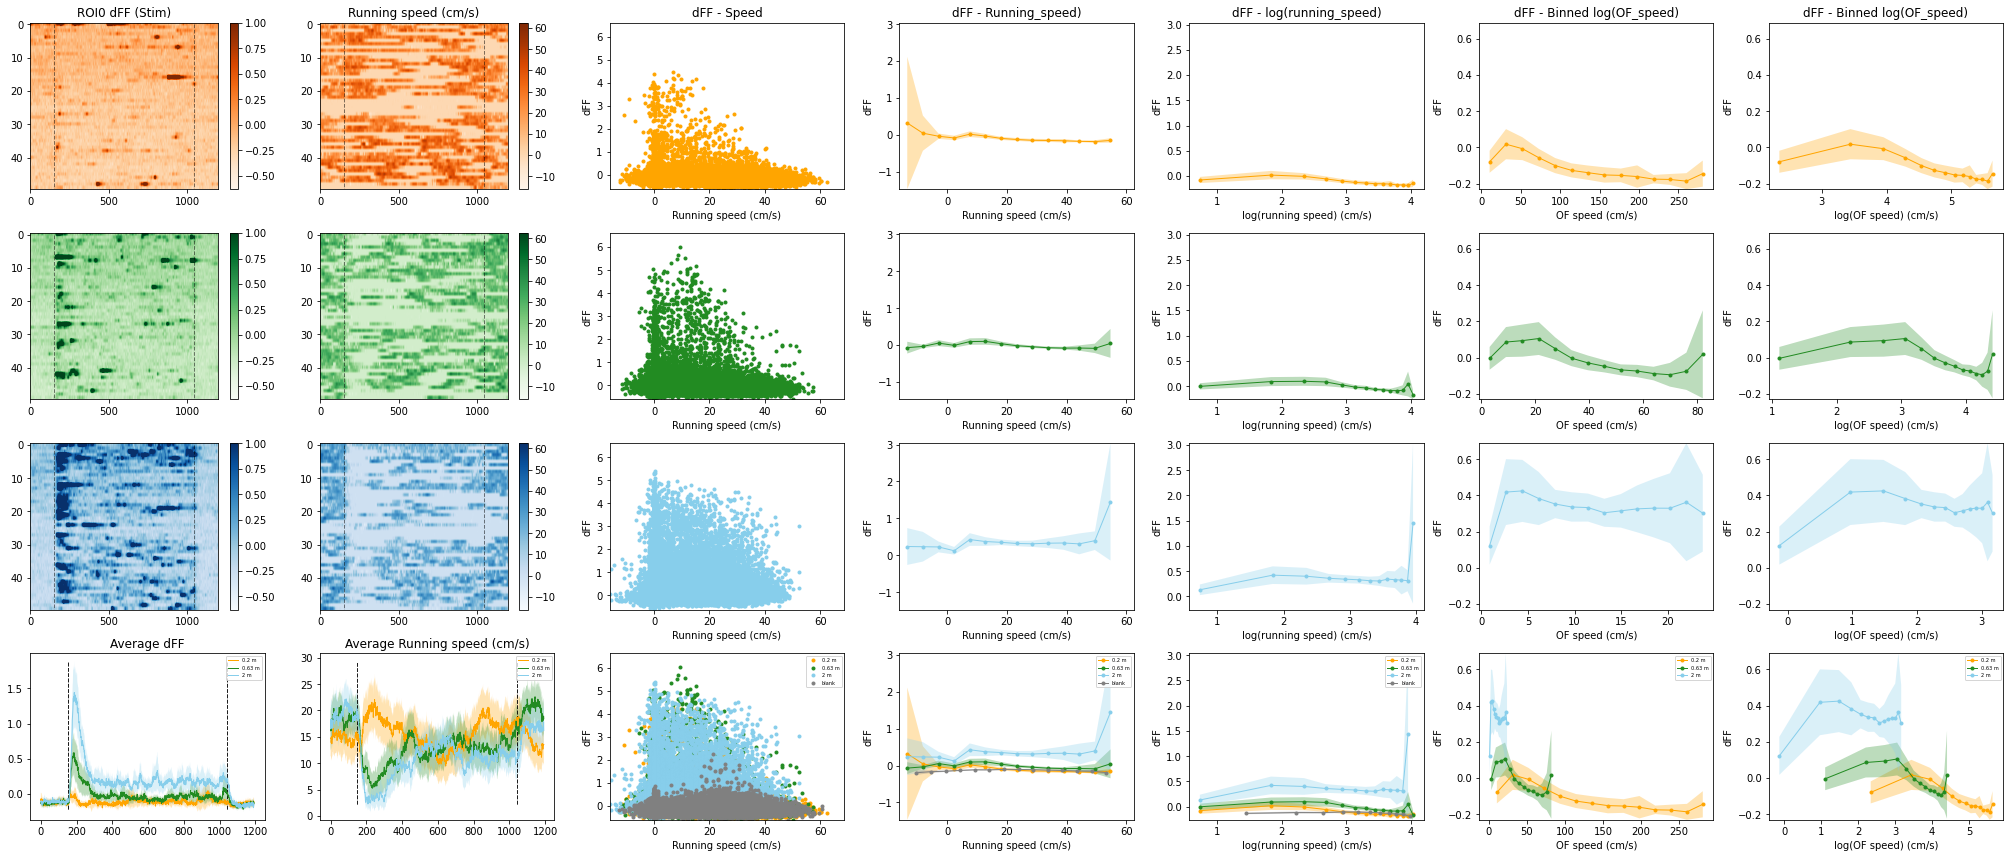

<ipython-input-14-3220caf1a922>:174: RuntimeWarning: invalid value encountered in log
  plot_line_with_error(xarr=np.log(binned_stats_blank['bin_centers'][0,:]), arr=binned_stats_blank['bin_means'][0,:], CI_low=CI_low, CI_high=CI_high,


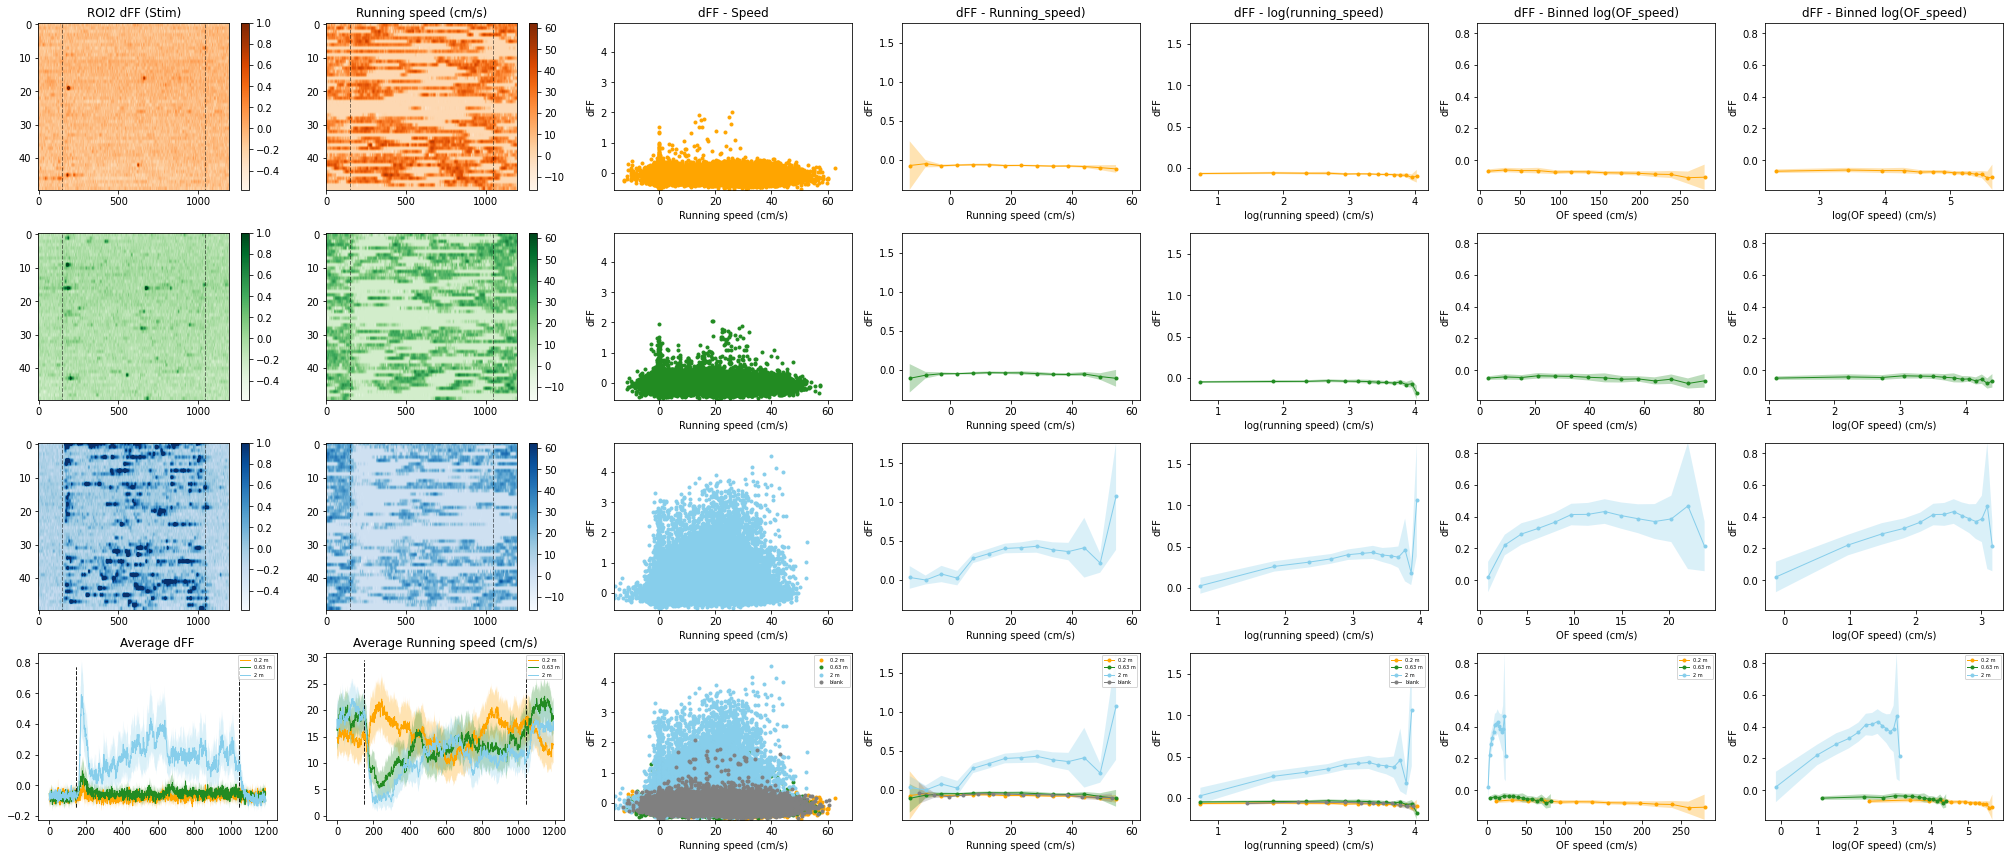

In [15]:
# Test plotting
plot_heatmap_dff_speed(which_rois[:2], dffs, speeds, depth_list, stim_dict, speed_bins=15, plot_dir='', plot_fname='Test_dff_speed_heatmap.pdf', colors=['Oranges','Greens','Blues'], blank_period=5, frame_rate=30)


In [ ]:
save_prefix = 'plots/heatmaps_binned_RS_OF/'
if not os.path.exists(analysis_folder+save_prefix):
    os.makedirs(analysis_folder+save_prefix)
rois_mins, rois_maxs = segment_arr(np.arange(len(which_rois)), segment_size = 20)
# rois_mins, rois_maxs = segment_arr(np.arange(2),segment_size = 2)
for rois_min, rois_max in zip(rois_mins, rois_maxs):
    select_rois = which_rois[rois_min:rois_max]
    plot_heatmap_dff_speed(select_rois, dffs_ast, speeds, depth_list, stim_dict, speed_bins=15, plot_dir=analysis_folder, plot_fname=save_prefix+'ROIs'+str(which_rois[rois_min])+'-'+str(which_rois[rois_max-1])+'_dff_speed_heatmap.pdf', colors=['Oranges','Greens','Blues'], blank_period=5, frame_rate=30)
    
    
    

Done saving ROI: 0
Done saving ROI: 1
Done saving ROI: 2
Done saving ROI: 3
Done saving ROI: 4
Done saving ROI: 5
Done saving ROI: 6
Done saving ROI: 7
Done saving ROI: 8
Done saving ROI: 9
Done saving ROI: 10
Done saving ROI: 11
Done saving ROI: 12
Done saving ROI: 13
Done saving ROI: 14
Done saving ROI: 15
Done saving ROI: 16
Done saving ROI: 17
Done saving ROI: 18
Done saving ROI: 19
Done saving ROI: 0
Done saving ROI: 1
Done saving ROI: 2
Done saving ROI: 3
Done saving ROI: 4
Done saving ROI: 5
Done saving ROI: 6
Done saving ROI: 7
Done saving ROI: 8
Done saving ROI: 9
Done saving ROI: 10
Done saving ROI: 11
Done saving ROI: 12
Done saving ROI: 13
Done saving ROI: 14
Done saving ROI: 15
Done saving ROI: 16
Done saving ROI: 17
Done saving ROI: 18
Done saving ROI: 19
Done saving ROI: 0
Done saving ROI: 1
Done saving ROI: 2
Done saving ROI: 3
Done saving ROI: 4
Done saving ROI: 5
Done saving ROI: 6
Done saving ROI: 7
Done saving ROI: 8
Done saving ROI: 9
Done saving ROI: 10
Done savin

16

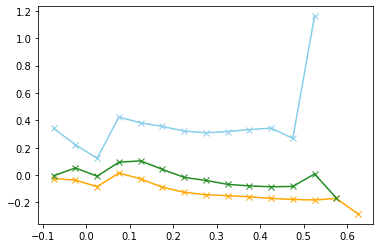

In [71]:
speed_arr = create_speed_arr(speeds, depth_list, stim_dict, blank_period=0)
trace_arr = create_trace_arr_per_roi(0,dffs, depth_list, stim_dict, blank_period=0)
for idepth, linecolor in zip(range(len(depth_list)),['orange','forestgreen','skyblue']):
    bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(speed_arr[idepth,:,:].flatten(), trace_arr[idepth,:,:].flatten(), statistic='mean', bins=np.arange(-0.1,0.7,0.05))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    # plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=2, label='binned statistic of data', color=linecolor)
    plt.plot(bin_centers, bin_means,'x-',color=linecolor)
binnumber
len(np.arange(-0.1,0.7,0.05))

In [38]:
bin_means

array([0.34145067, 0.22160614, 0.12276817, 0.42385158, 0.38209168,
       0.3554187 , 0.32140424, 0.30921056, 0.31823581, 0.33211719,
       0.34305817, 0.26831375, 1.16049062,        nan,        nan])

In [30]:
bin_edges

array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6])